# Plot super-resolution predictions used in multiple figures

## Settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# hack for dask/python3.9 compatibility issues (https://github.com/dask/distributed/issues/4168)
import multiprocessing.popen_spawn_posix
import os
from pathlib import Path

import dask.distributed as dd
import mosaiks.config as c
import mosaiks.plotting.plot_superres as ps
import mosaiks.solve.superres as sr
import numpy as np
import scipy.ndimage
import xarray as xr

In [3]:
N_IMAGES_TO_DISPLAY = 10
FACTORS_R2 = c.superres["factors_to_test"]

TRUE_TASK_NAME = c.superres["test_label"]
PRED_TASK_NAMES = c.superres["tasks_to_predict"]
N_PRED_IMAGES = c.superres["n_pred_images"]

INT_DATA_DIR = Path(c.out_dir) / "superres" / "sr_n_{0}".format(N_PRED_IMAGES)
TRUE_HMAPS_FPATH = (
    Path(c.data_dir) / "int" / "applications" / TRUE_TASK_NAME / "sr_true.npz"
)

In [4]:
# make output dir
this_out_dir = os.path.join(c.res_dir, "figures", "Fig4", "superres")
os.makedirs(this_out_dir, exist_ok=True)

## Load and transform data

1. Load data
2. Crop so that both ground truth and predictions cover the same window of the image, which is divisible by 32 (for downsampling)
3. Clip predictions based on config file min and max

In [5]:
# get ids
ids = np.load(INT_DATA_DIR / "ids.npy", allow_pickle=True)

# get scene-level truth
y_true = {t: np.load(INT_DATA_DIR / f"{t}_true_vals.npy") for t in PRED_TASK_NAMES}

# get true pixel-level values
data_true = np.load(TRUE_HMAPS_FPATH)
all_hmaps = data_true["frames"]

# convert to DataArray to facilitate reindexing on id
all_hmaps = xr.DataArray(
    all_hmaps,
    coords={
        "image_id": data_true["ids"],
        "i": range(all_hmaps.shape[1]),
        "j": range(all_hmaps.shape[2]),
    },
    dims=["image_id", "i", "j"],
)
hmaps_true = all_hmaps.sel(image_id=ids).values

# make sure to account for nans in int
hmaps_true = np.where(hmaps_true != 255, hmaps_true, np.nan)

# load predicted values and crop so that they all have the same window, which is divisible by 32
hmaps_pred = {t: np.load(INT_DATA_DIR / f"{t}_pred_maps.npy") for t in PRED_TASK_NAMES}

In [6]:
# drop images with null ground truth pixels b/c messes with means
valid_images = ~np.isnan(hmaps_true).any(axis=(1, 2))
hmaps_true = hmaps_true[valid_images]
hmaps_pred = {k: v[valid_images] for k, v in hmaps_pred.items()}
ids = ids[valid_images]
y_true = {k: v[valid_images] for k, v in y_true.items()}

# Fig S13: performance with varying resolution

First we use a gaussian filter to smooth predictions

In [7]:
client = dd.Client()

# load best sigma
sigma_fpath = (
    Path(c.data_dir)
    / "int"
    / f"superres_hp_eval_n_{c.superres['val_set_size']}"
    / "preds.npz"
)
sigma = int(np.load(sigma_fpath)["best_sigma"])

# filter images
hmaps_pred_filtered = {}
for k in PRED_TASK_NAMES:
    print(f"Computing filters for task: {k}")
    ftrs = client.map(
        lambda x: scipy.ndimage.gaussian_filter(x, sigma=sigma), list(hmaps_pred[k])
    )
    hmaps_pred_filtered[k] = np.stack(client.gather(ftrs))

client.close()

Computing filters for task: population
Computing filters for task: treecover


Next, we crop the extra 1-pixel border around the true values, relative to the predicted values (caused by using the 3x3 filter for generating MOSAIKS features). We also crop the true and predicted rasters so that they are evenly divisible by each super-resolution factor (e.g. 2x, 4x, etc.) for which we will be making predictions.

In [9]:
cropped = sr.crop_rasters_for_sr(
    FACTORS_R2[-1], *([hmaps_true] + [hmaps_pred_filtered[t] for t in PRED_TASK_NAMES])
)
hmaps_true_cropped = cropped[0]
hmaps_pred_cropped = {t: cropped[tx + 1] for tx, t in enumerate(PRED_TASK_NAMES)}

for k in hmaps_pred_cropped.keys():
    assert hmaps_true_cropped.shape == hmaps_pred_cropped[k].shape

Next, we calculate within-image r2 for various scales of super-resolution prediction.

In [10]:
# choose SR pixel widths
widths_r2 = [int(hmaps_true_cropped.shape[1] / x) for x in FACTORS_R2]

# get clipping bounds
c_app = getattr(c, TRUE_TASK_NAME)
bounds = c_app["us_bounds_pred"]

# get r2
r2s_demeaned = sr.across_image_r2s(
    hmaps_pred_cropped[TRUE_TASK_NAME],
    hmaps_true_cropped,
    widths_r2,
    demean=True,
    clip=True,
    bounds=bounds,
)

112
56
28
14
7


In [11]:
for fx, f in enumerate(FACTORS_R2):
    print(f"R2 at {f}x: {r2s_demeaned[fx]:.2f}")

R2 at 2x: 0.54
R2 at 4x: 0.48
R2 at 8x: 0.41
R2 at 16x: 0.35
R2 at 32x: 0.31


Now plot:

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f77de4b3550>)

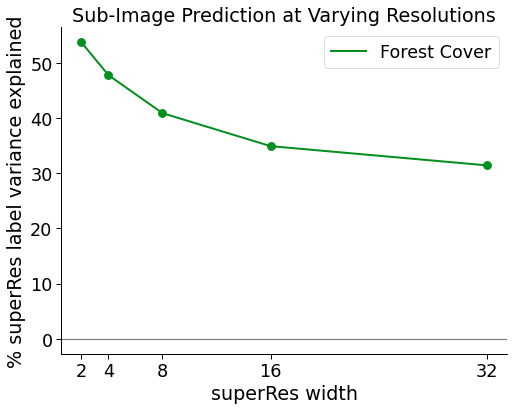

In [12]:
ps.plot_sr_vs_delta(
    FACTORS_R2,
    widths_r2,
    r2s_demeaned,
    save_path=os.path.join(this_out_dir, "fig4c_lineplot.pdf"),
)

# Fig S12
One of these is also in Fig 4C

/shares/lab/Datasets/Remote_Sensing/replication/mosaiks_IB/code/mosaiks/plotting/plot_superres.py:129: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  )


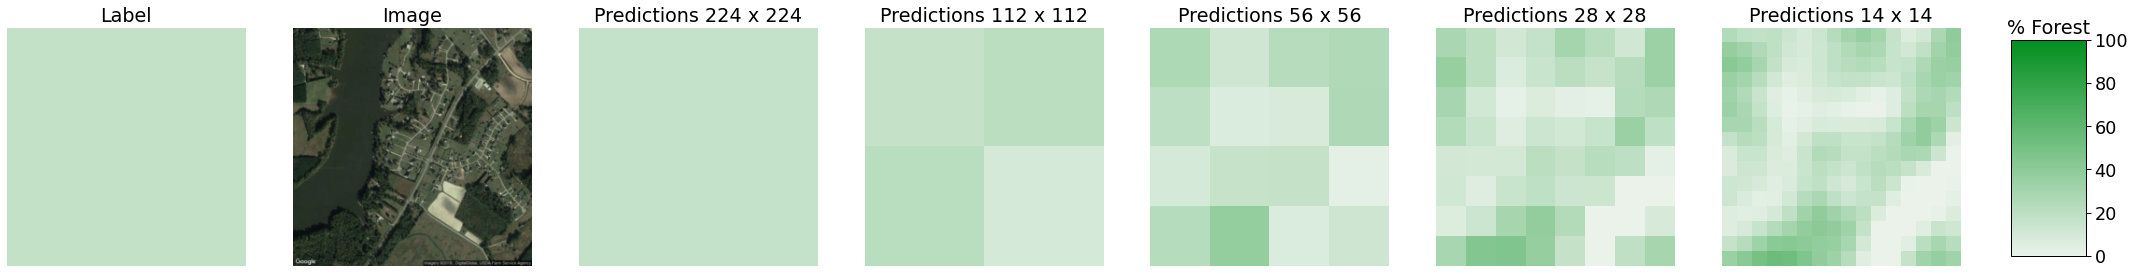

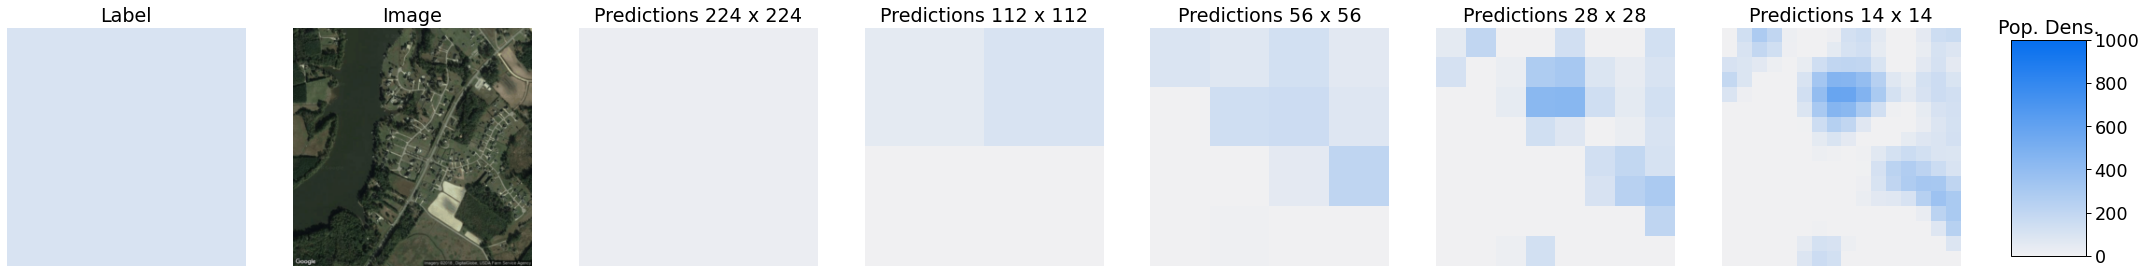

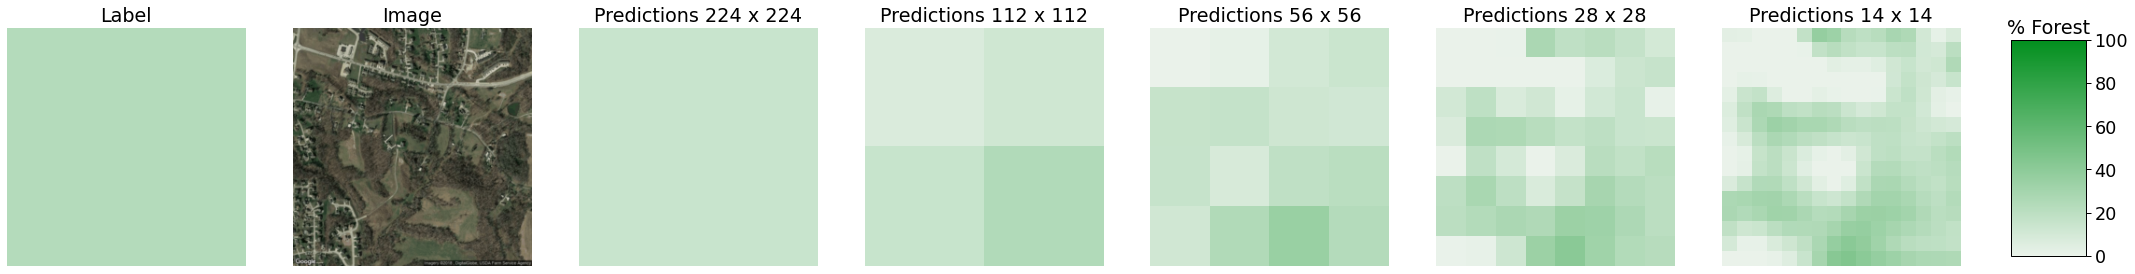

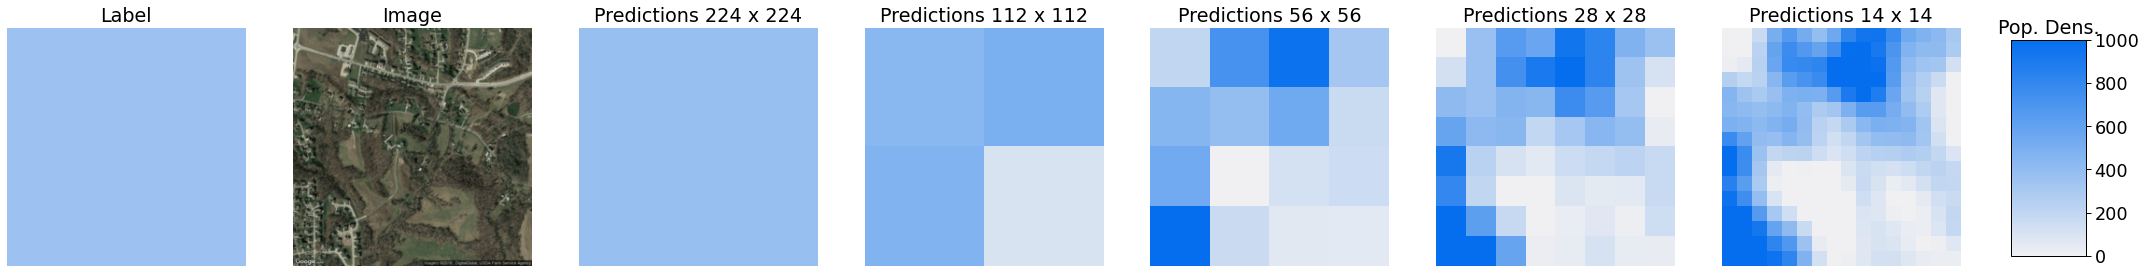

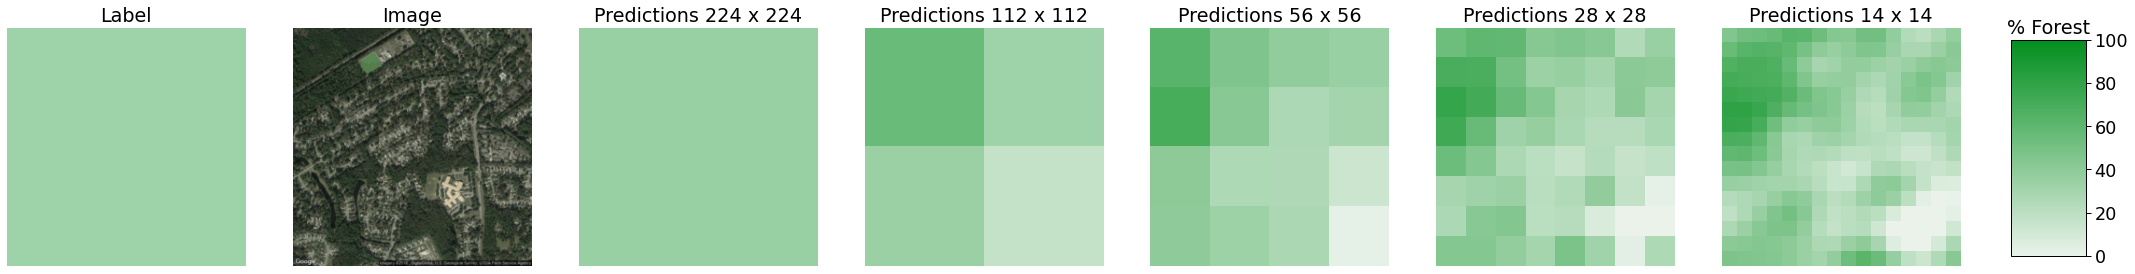

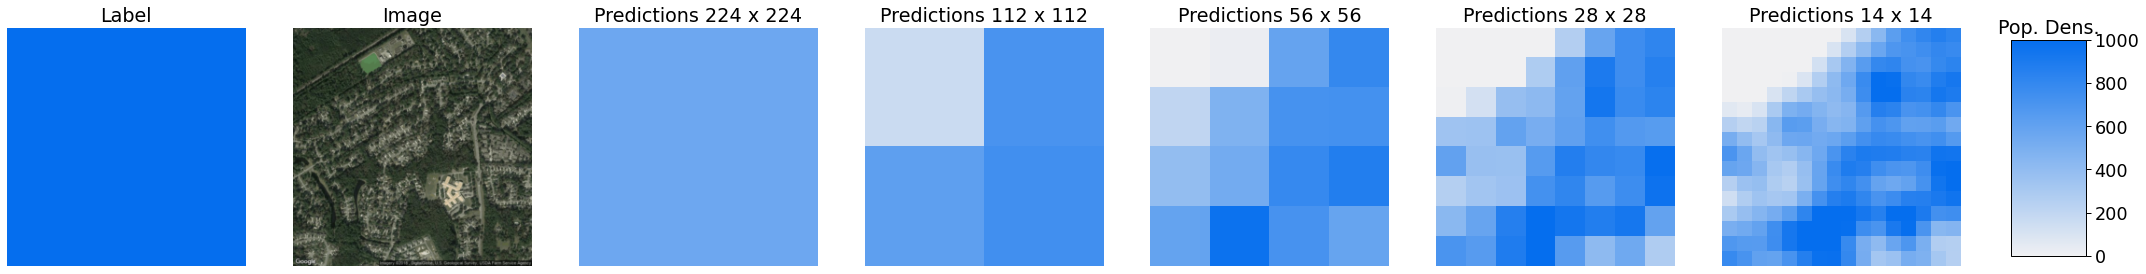

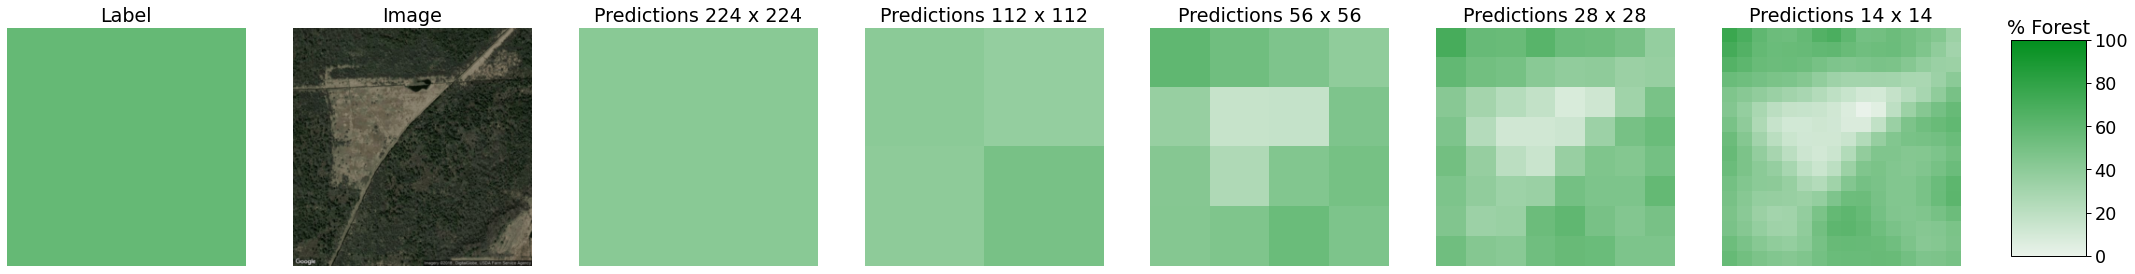

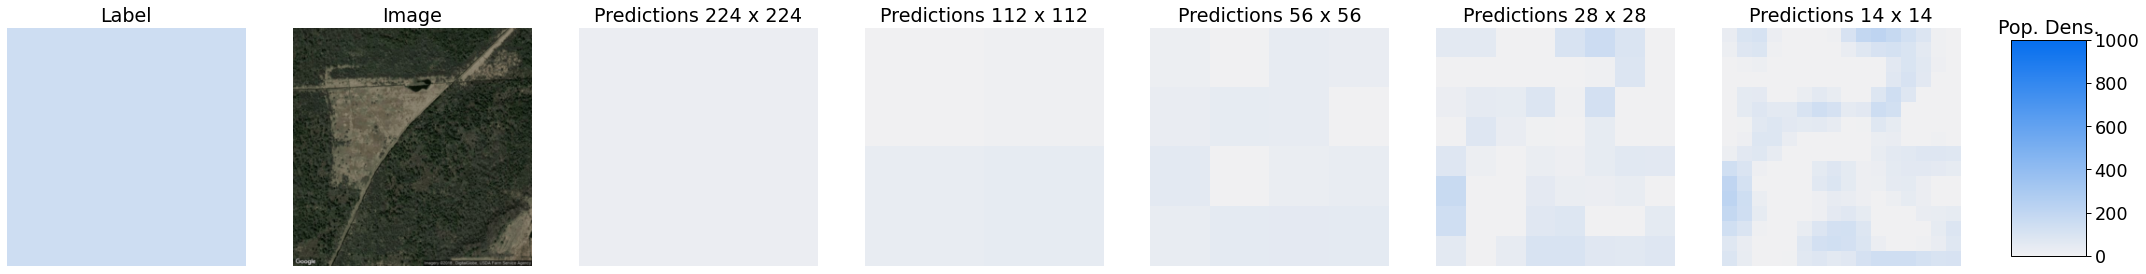

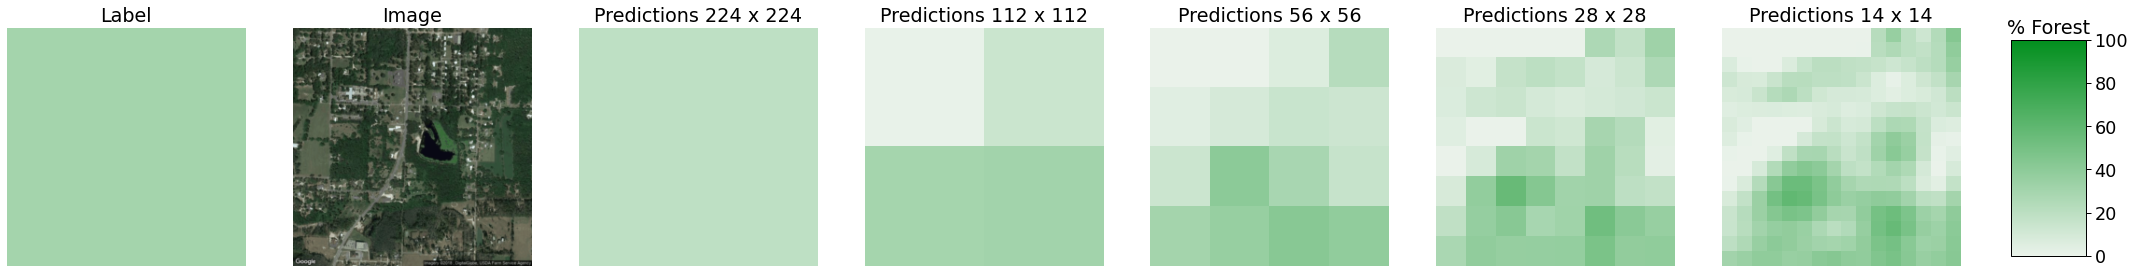

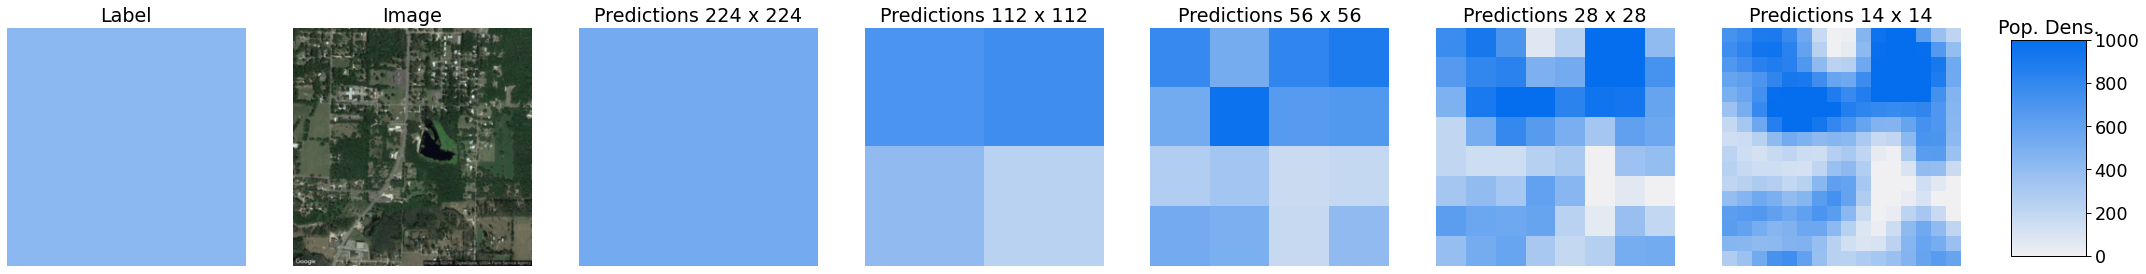

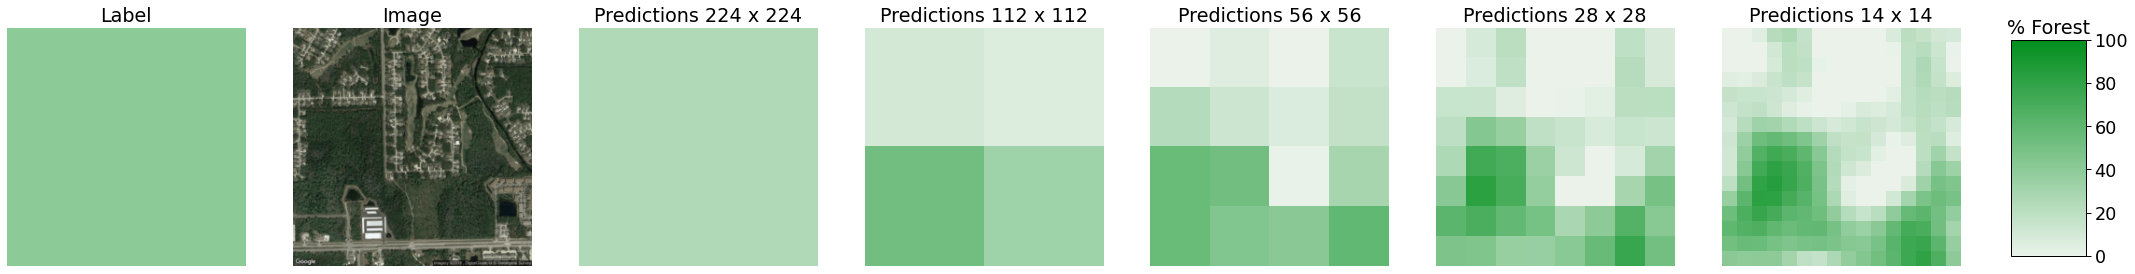

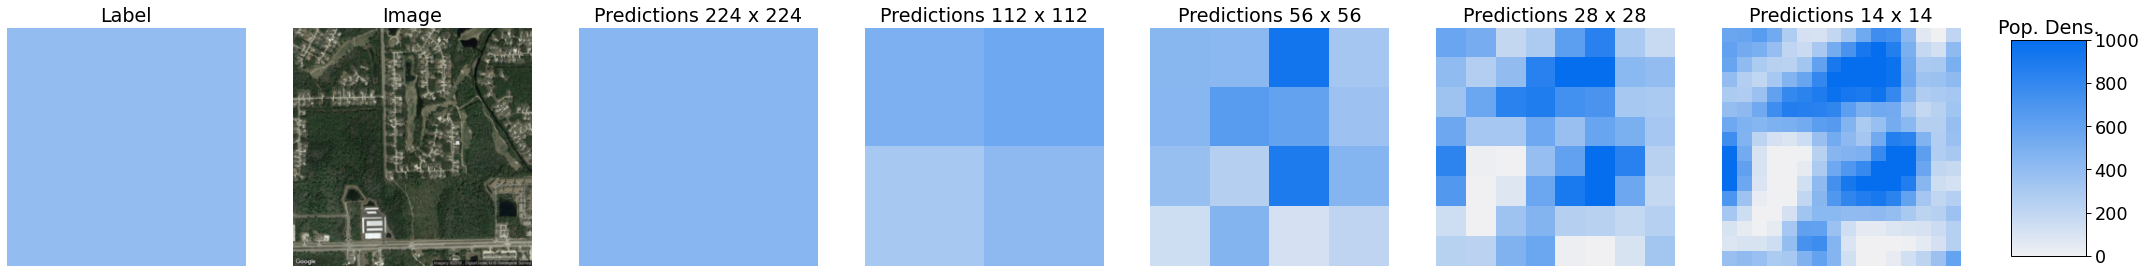

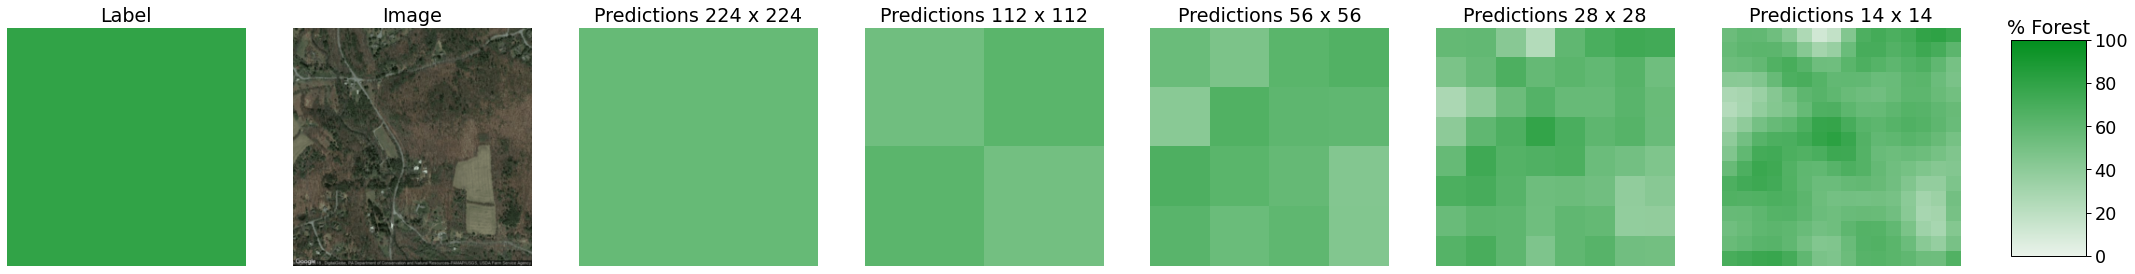

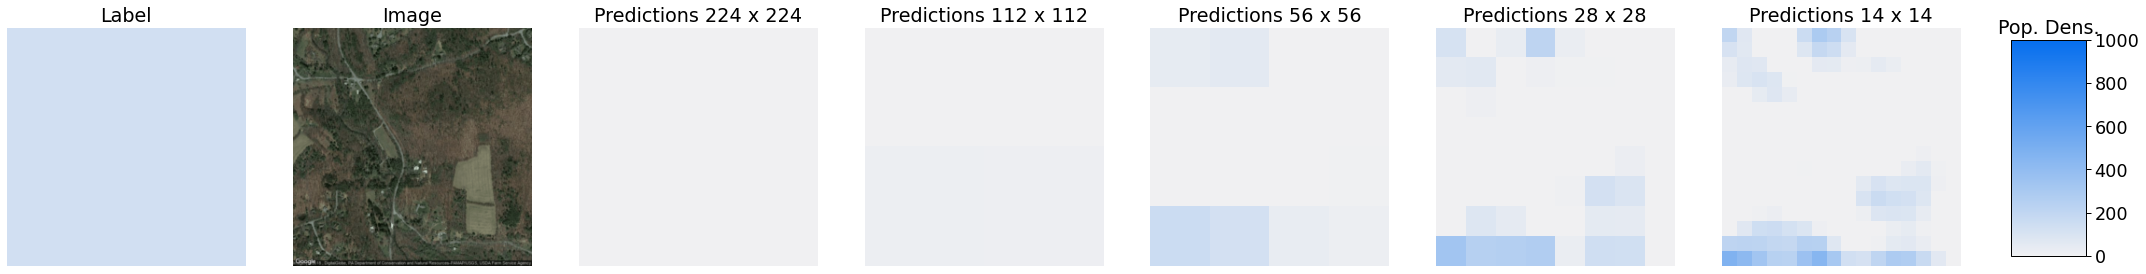

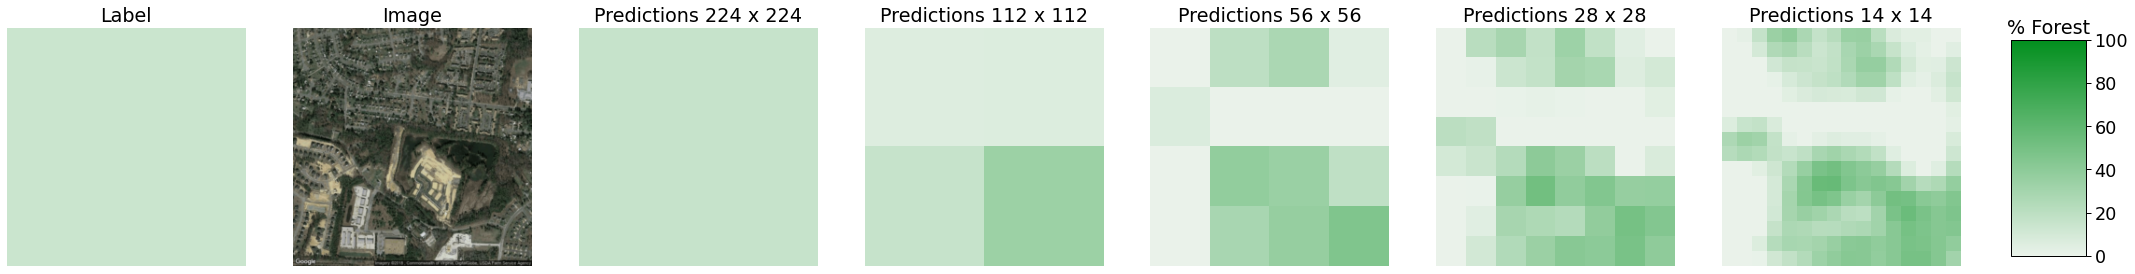

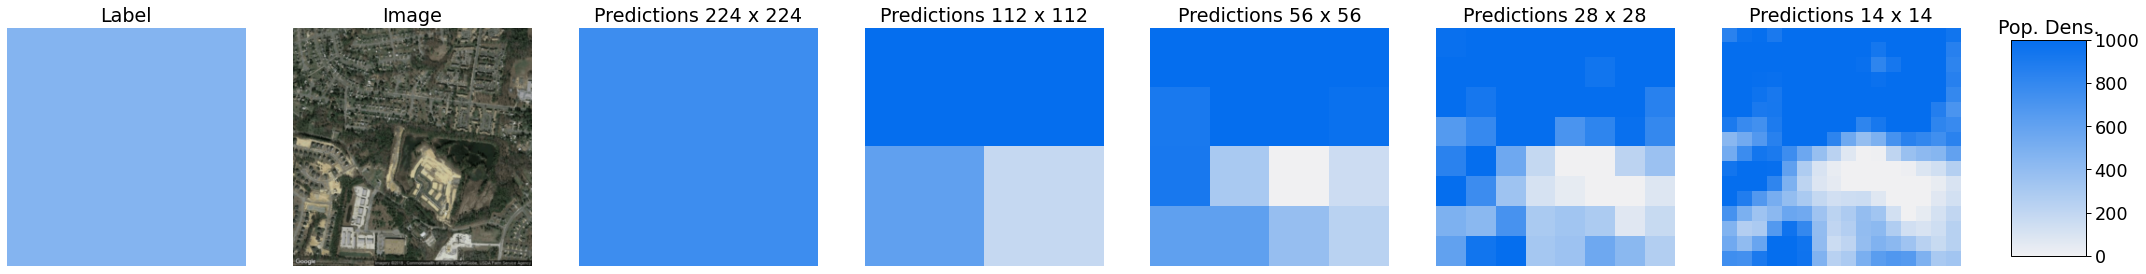

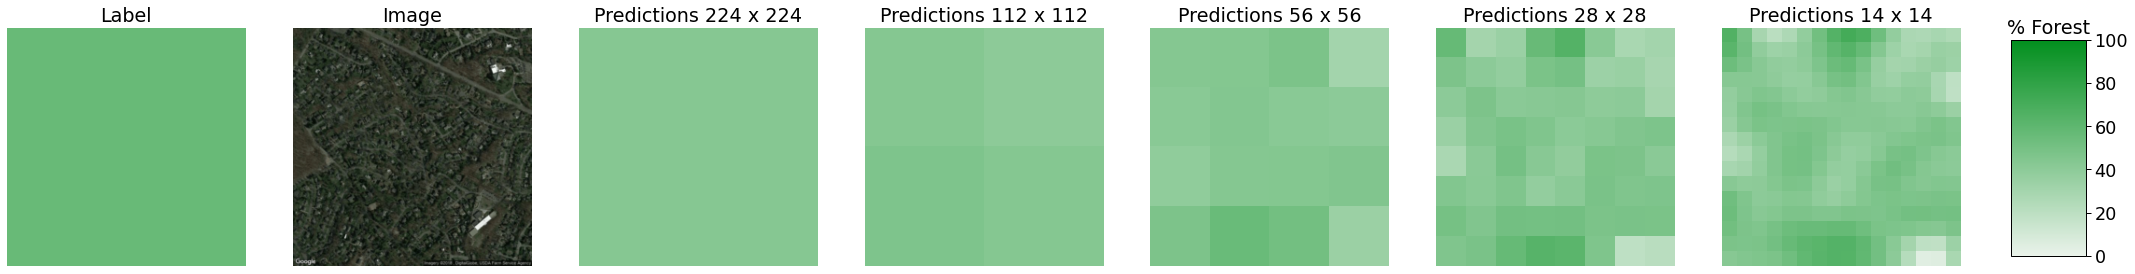

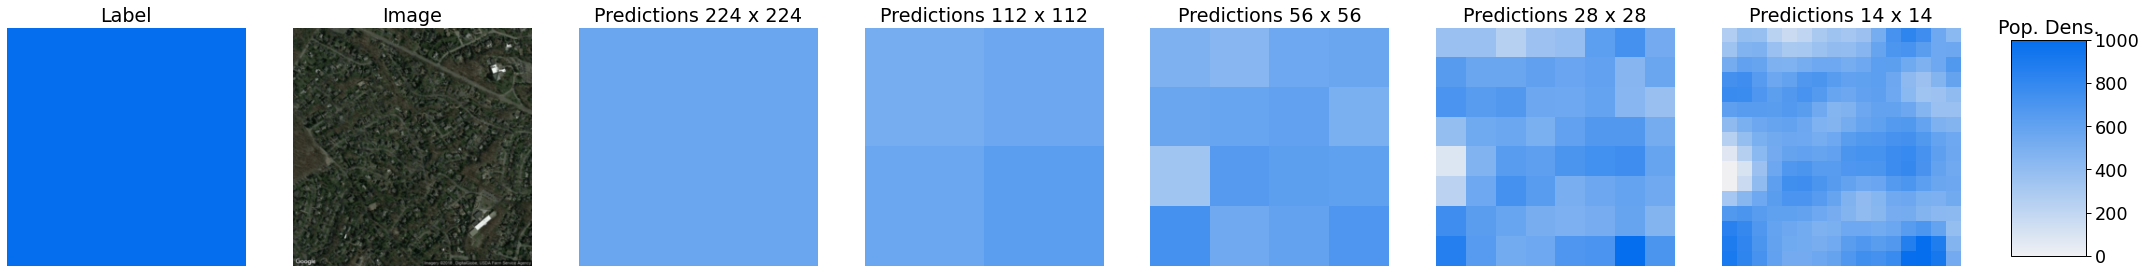

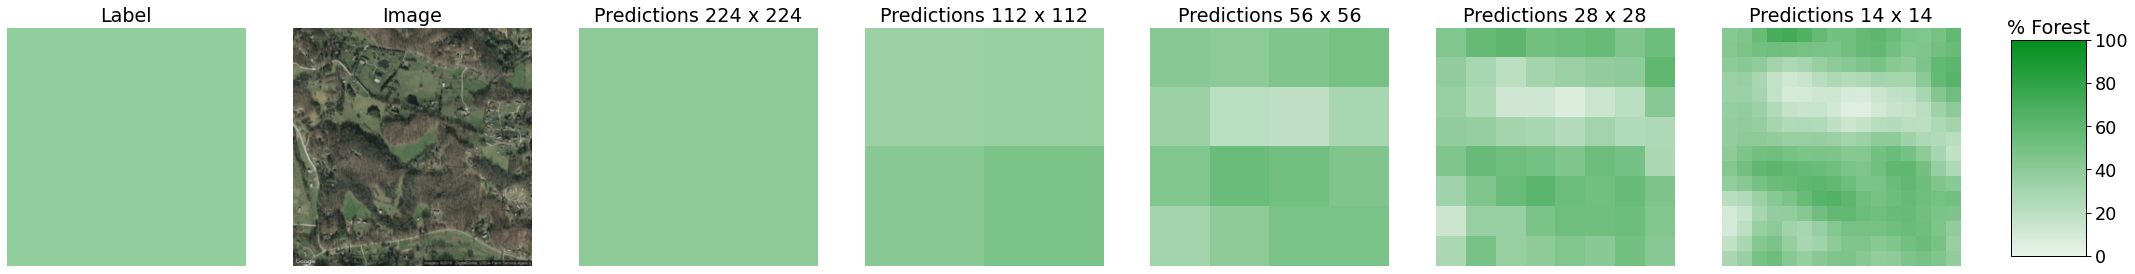

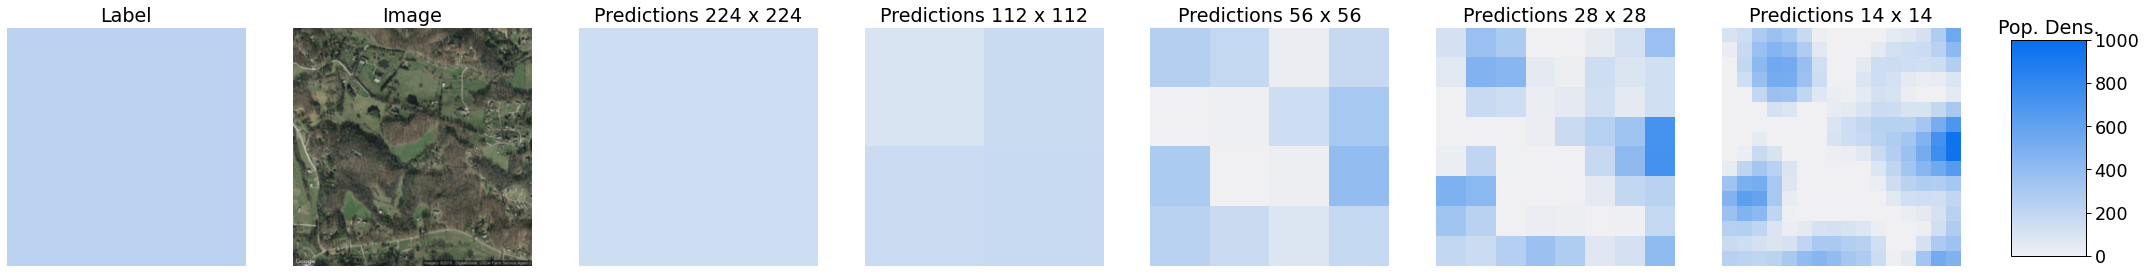

In [10]:
# define valid parameters for selection in figure S12, and pick the first N of them
ids_to_plot = ids[(y_true["population"] > 100) & (y_true["treecover"] > 10)][
    :N_IMAGES_TO_DISPLAY
]
ix_to_plot = [list(ids).index(i) for i in ids_to_plot]

plot_tree = hmaps_pred_cropped["treecover"][ix_to_plot]
plot_pop = hmaps_pred_cropped["population"][ix_to_plot]
true_tree = y_true["treecover"][ix_to_plot]
true_pop = y_true["population"][ix_to_plot]

for i, id_to_match in enumerate(ids_to_plot):
    ps.plot_both(
        id_to_match,
        plot_tree[i],
        plot_pop[i],
        true_tree[i],
        true_pop[i],
        (1, 255 - hmaps_true_cropped.shape[-1]),
        widths=[224, 112, 56, 28, 14],
        save_dir=this_out_dir,
    )

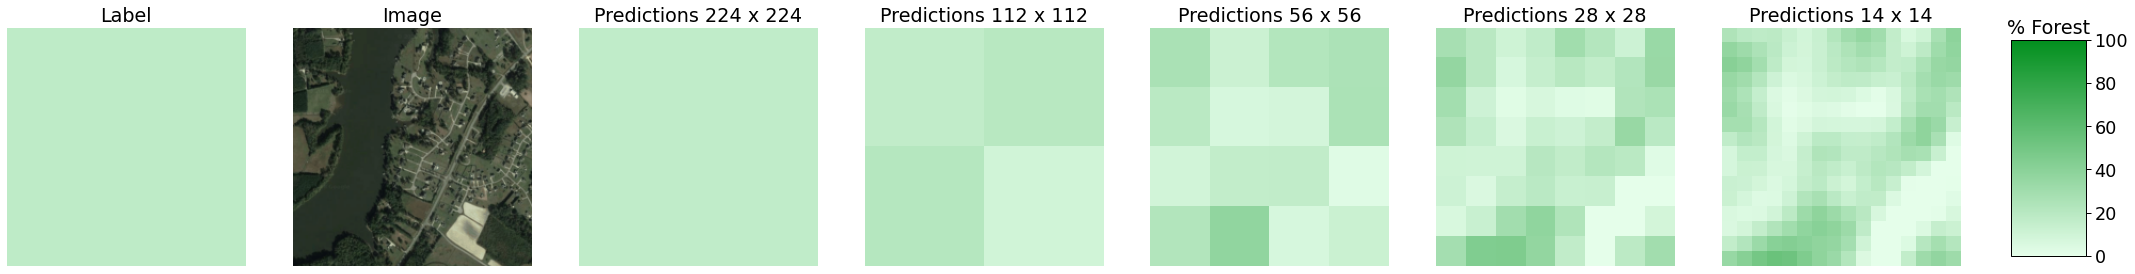

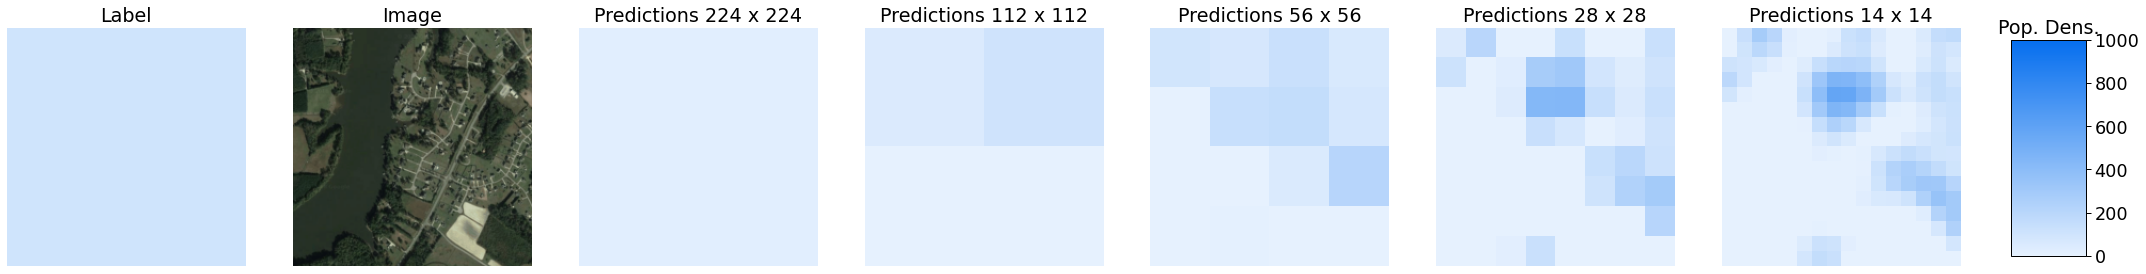

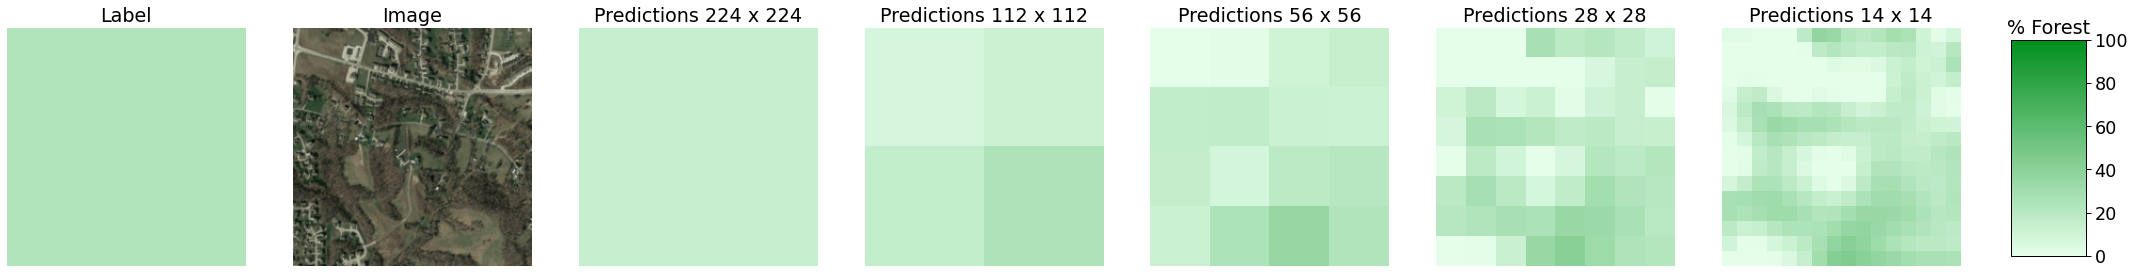

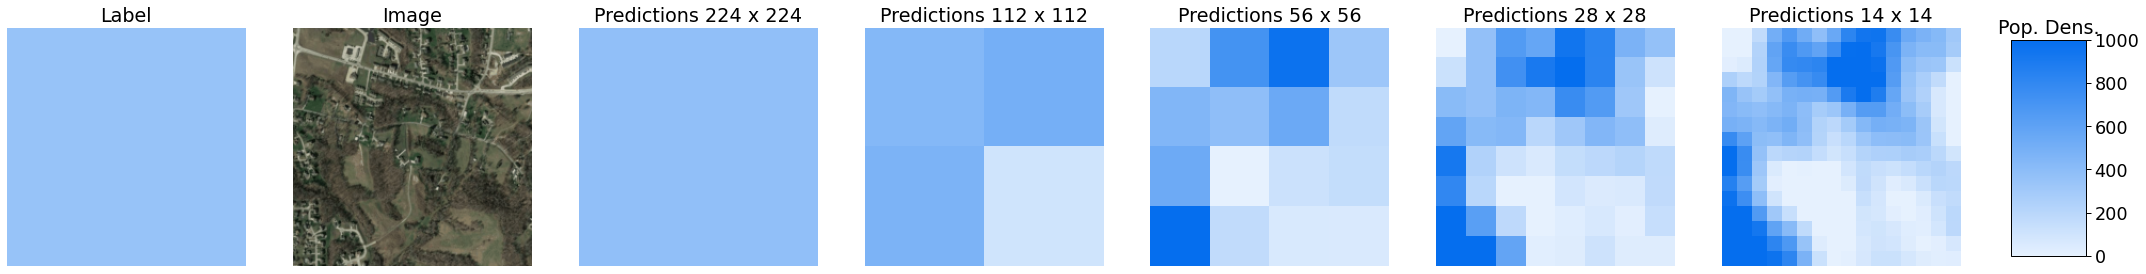

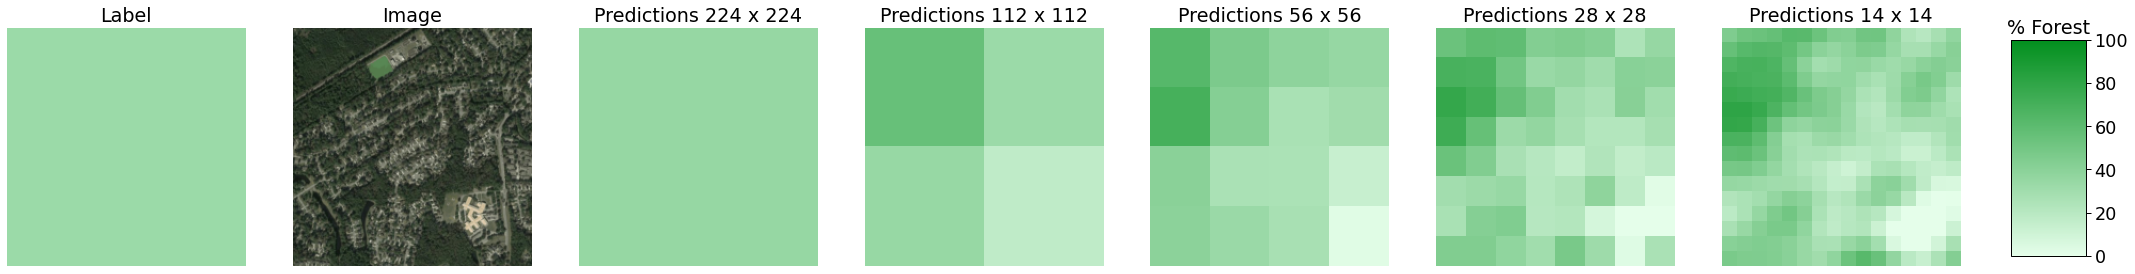

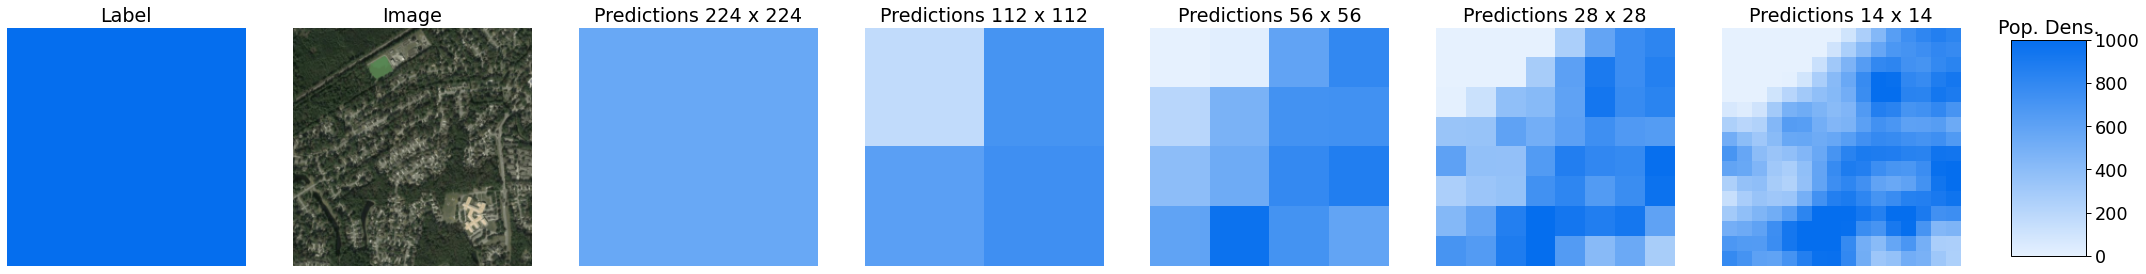

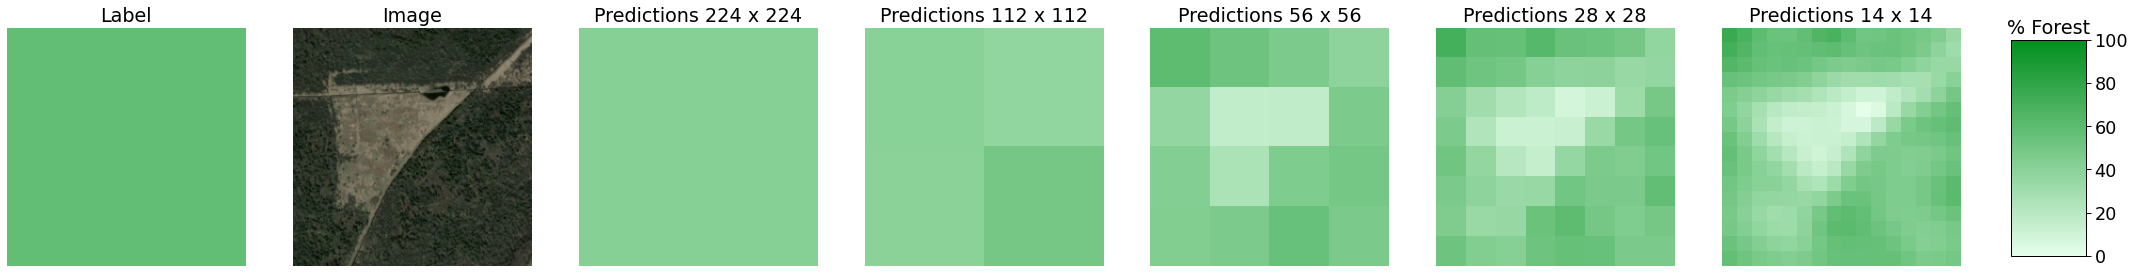

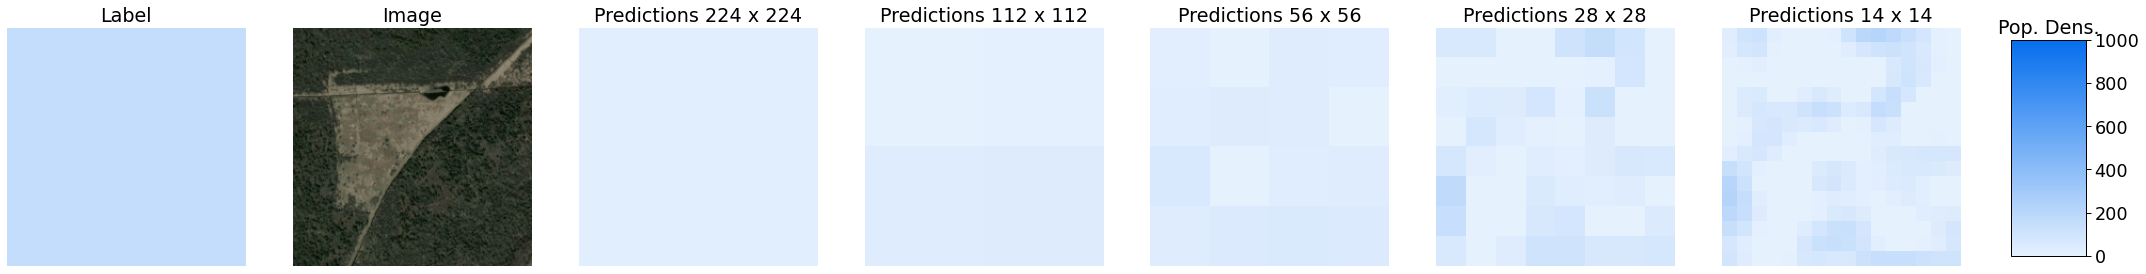

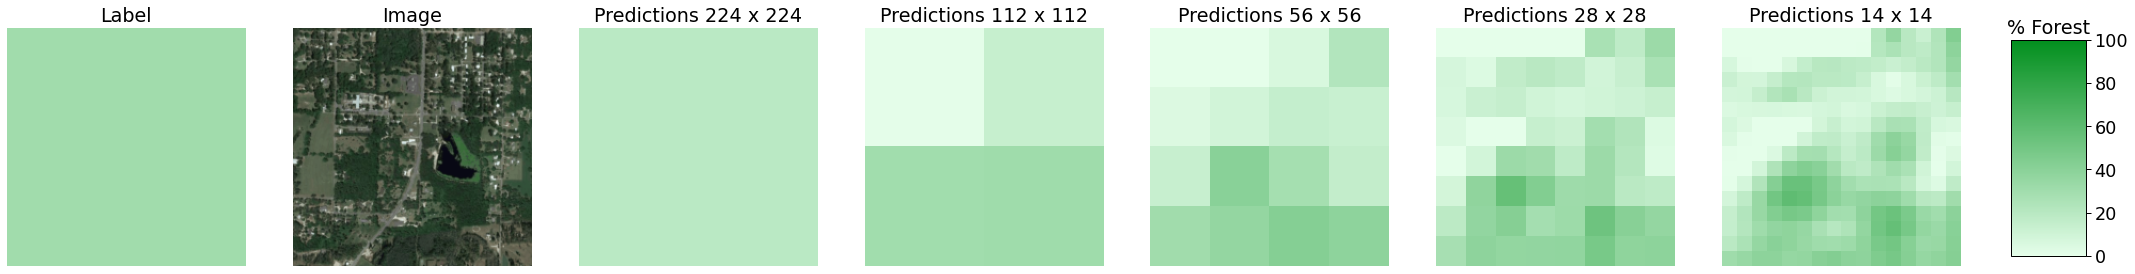

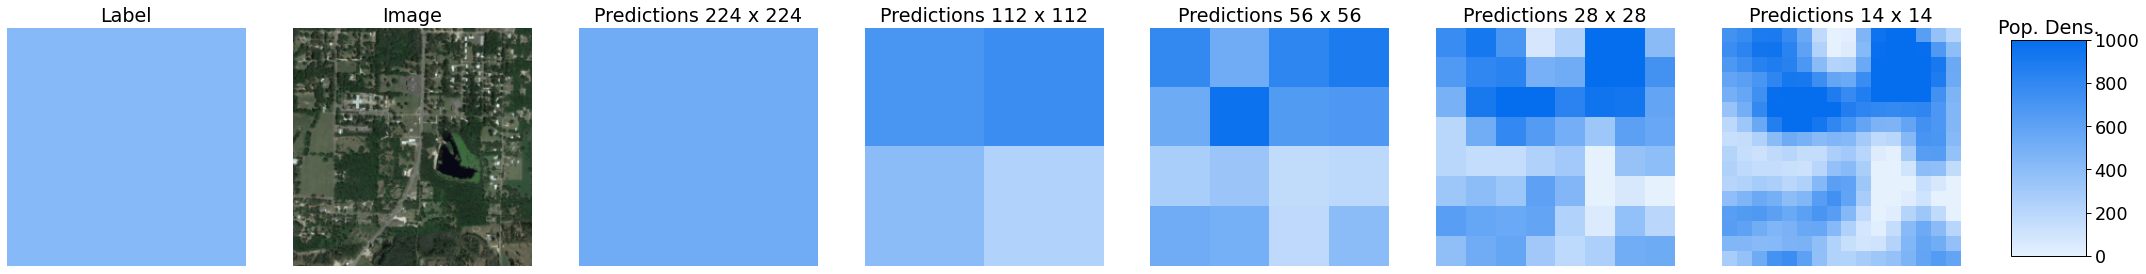

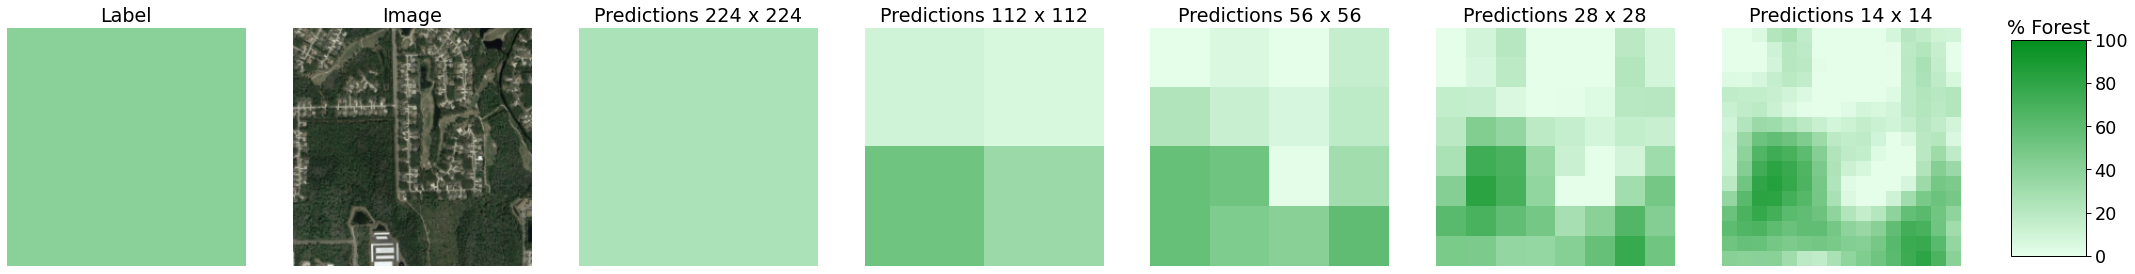

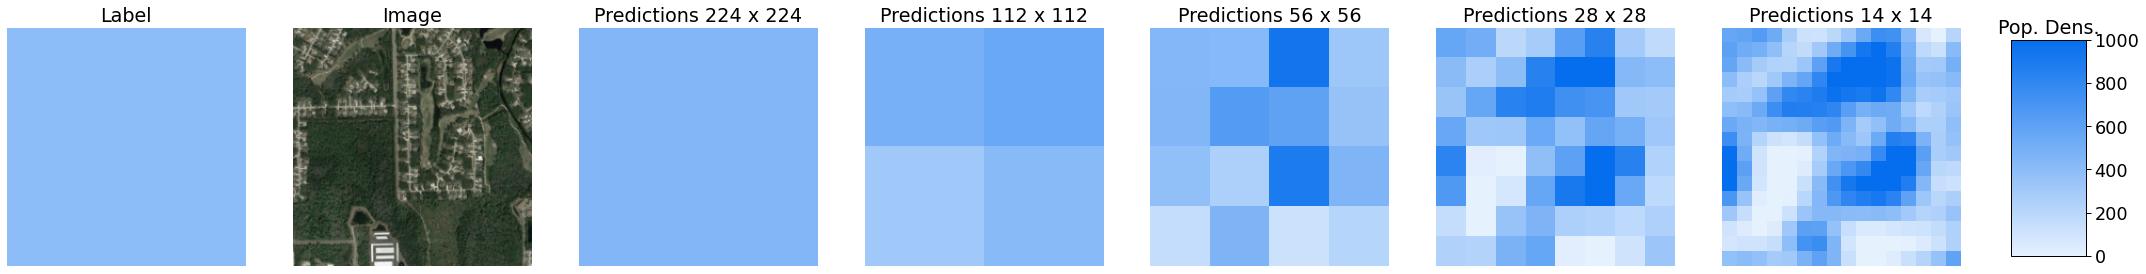

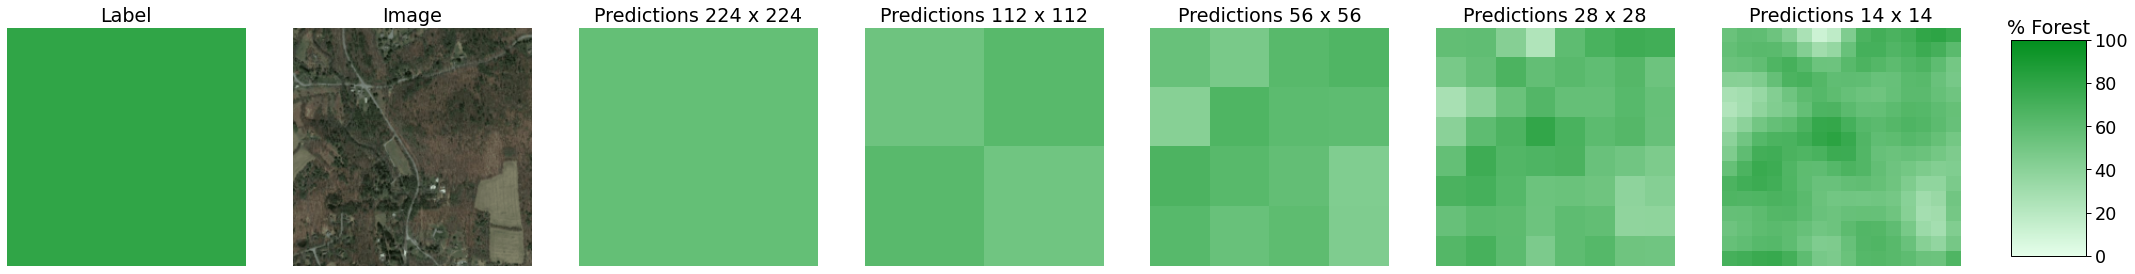

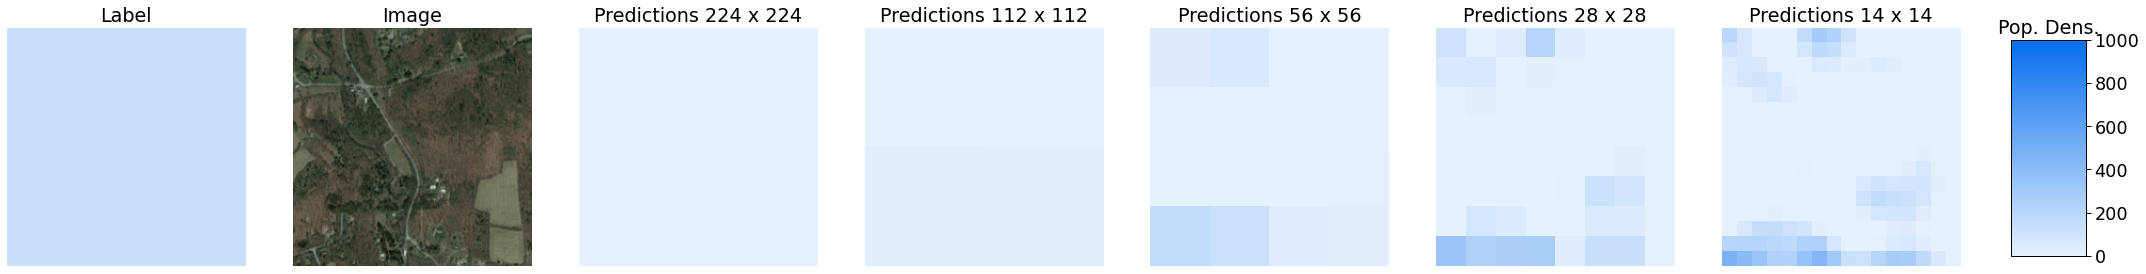

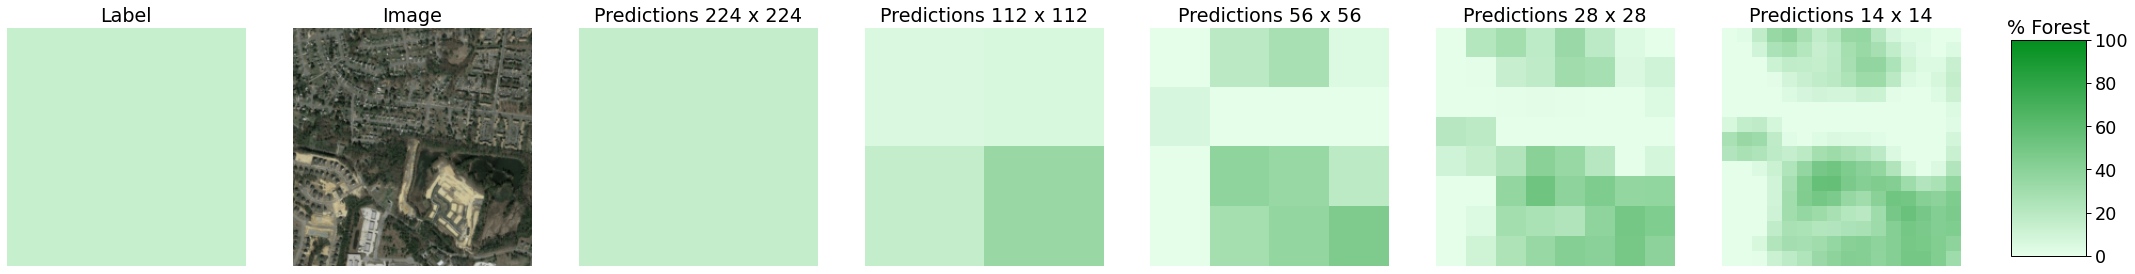

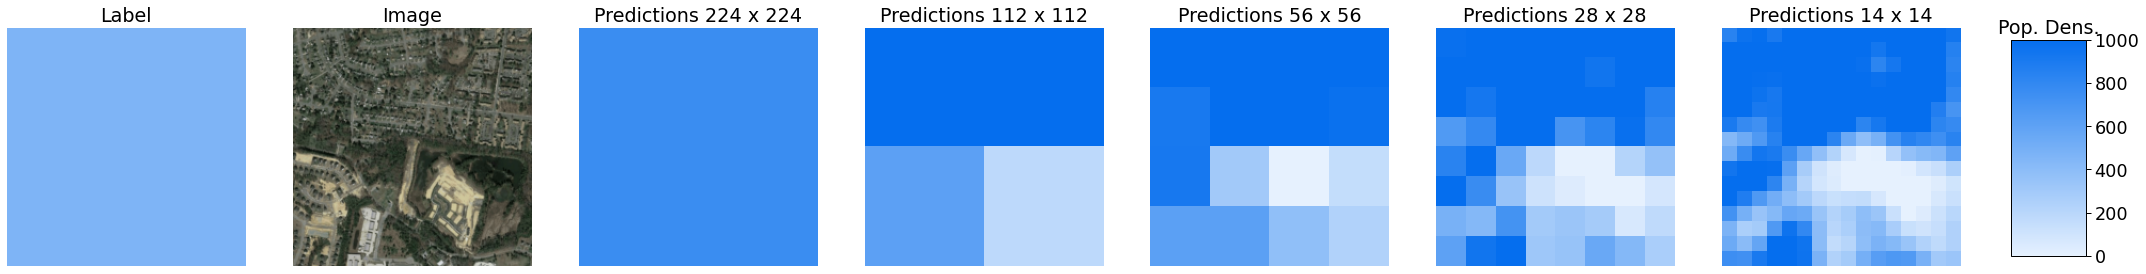

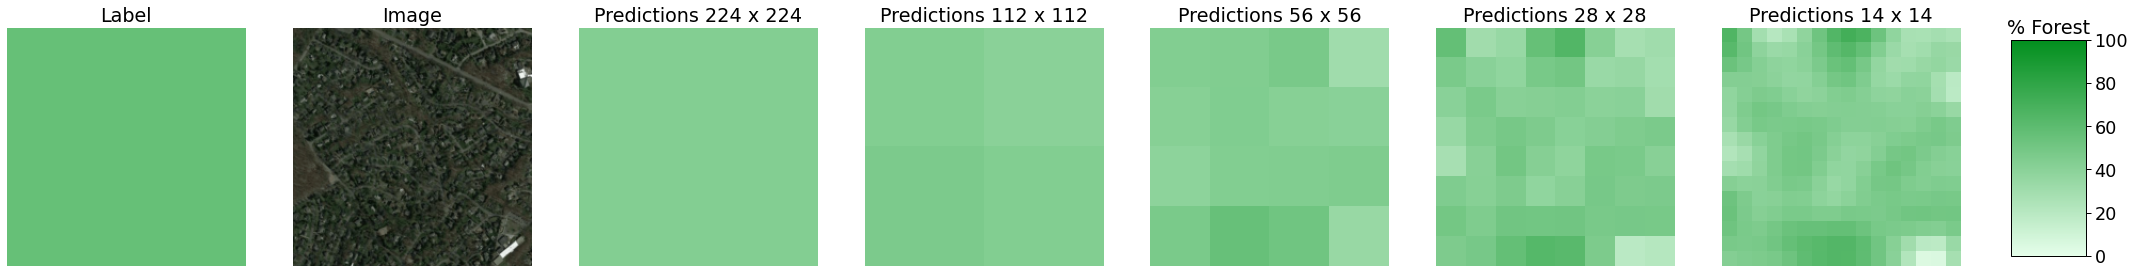

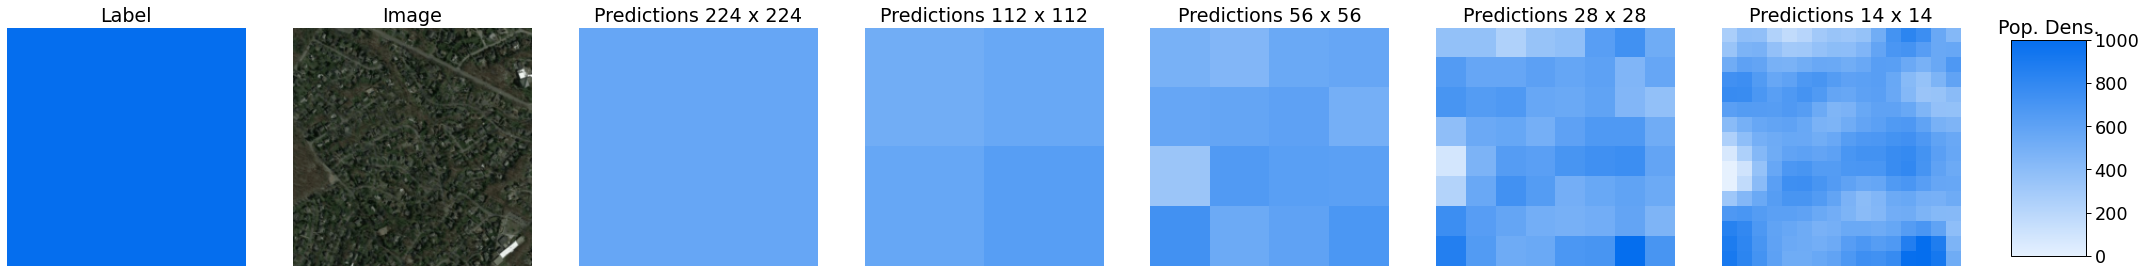

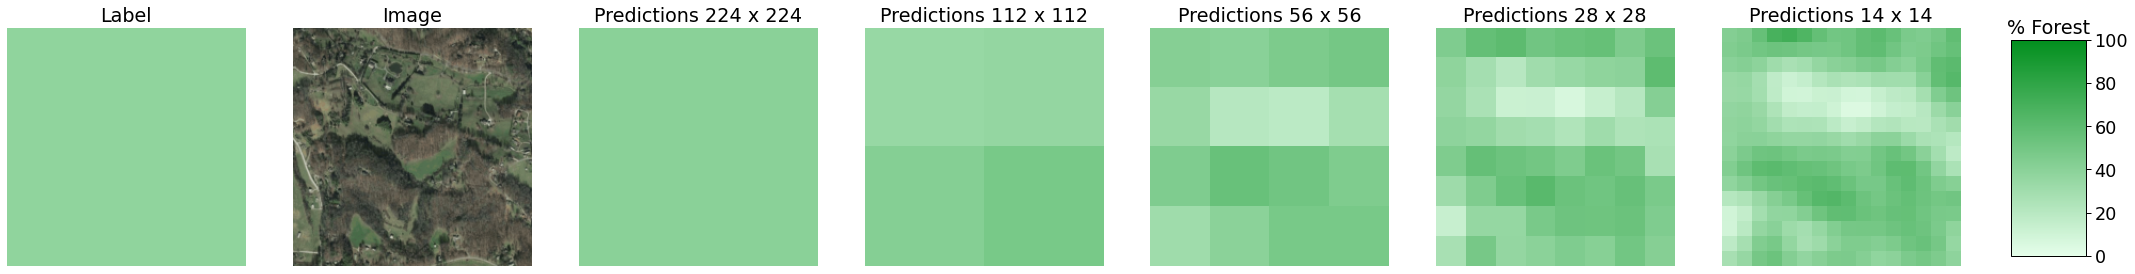

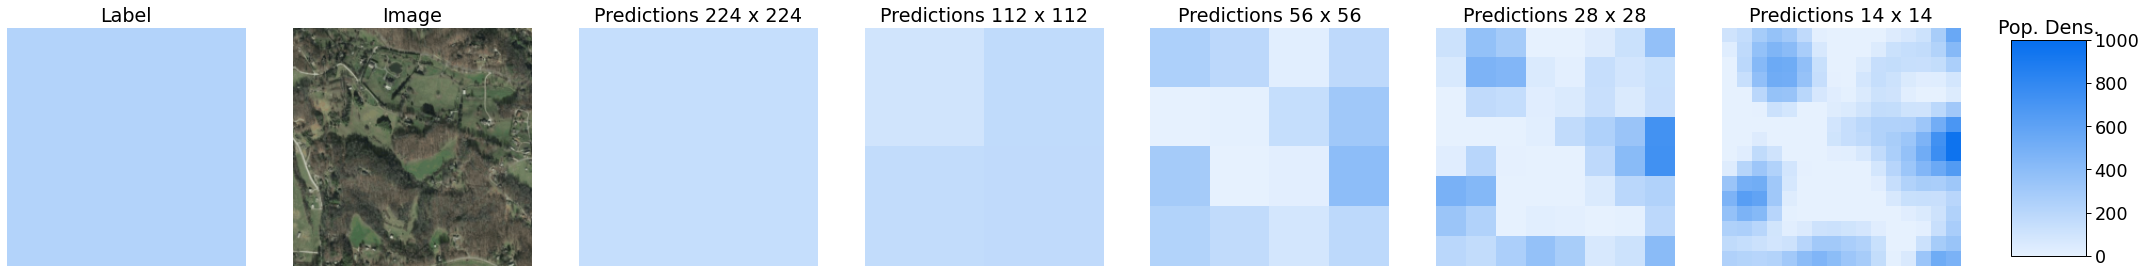

In [37]:
# define valid parameters for selection in figure S12, and pick the first N of them
ids_to_plot = ids[(y_true["population"] > 100) & (y_true["treecover"] > 10)][
    :N_IMAGES_TO_DISPLAY
]
ix_to_plot = [list(ids).index(i) for i in ids_to_plot]

plot_tree = hmaps_pred_cropped["treecover"][ix_to_plot]
plot_pop = hmaps_pred_cropped["population"][ix_to_plot]
true_tree = y_true["treecover"][ix_to_plot]
true_pop = y_true["population"][ix_to_plot]

for i, id_to_match in enumerate(ids_to_plot):
    ps.plot_both(
        id_to_match,
        plot_tree[i],
        plot_pop[i],
        true_tree[i],
        true_pop[i],
        (1, 255 - hmaps_true_cropped.shape[-1]),
        widths=[224, 112, 56, 28, 14],
        save_dir=this_out_dir,
    )